In [1]:
import time
import os
import subprocess
import sys
import re
import argparse
import collections
import gzip
import math
import shutil
import matplotlib.pyplot as plt
import wandb
import numpy as np
import time
from datetime import datetime
import random

import seaborn as sns
%matplotlib inline
import logging
from silence_tensorflow import silence_tensorflow
#silence_tensorflow()
os.environ['TPU_LOAD_LIBRARY']='0'
os.environ['TF_ENABLE_EAGER_CLIENT_STREAMING_ENQUEUE']='False'
import tensorflow as tf


import tensorflow.experimental.numpy as tnp
import tensorflow_addons as tfa
from tensorflow import strings as tfs
from tensorflow.keras import mixed_precision
from scipy.stats.stats import pearsonr  
from scipy.stats.stats import spearmanr  
## custom modules
import src.aformer_TF_gc_separated as aformer
#import src.aformer_TF as aformer
from src.layers.layers import *
import src.metrics as metrics
from src.optimizers import *
import src.schedulers as schedulers
import src.utils as utils

import training_utils_aformer_TF_genecentered_separated as training_utils


from scipy import stats



2022-08-29 17:39:02.563895: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-29 17:39:02.563941: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.6.0 and strictly below 2.9.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.9.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the

In [2]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='node-15')
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
strategy = tf.distribute.TPUStrategy(resolver)

with strategy.scope():
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.FILE
    options.deterministic=False
    #options.experimental_threading.max_intra_op_parallelism = 1
    mixed_precision.set_global_policy('mixed_bfloat16')
    tf.config.optimizer.set_jit(True)
    #options.num_devices = 64

    BATCH_SIZE_PER_REPLICA = 1
    NUM_REPLICAS = strategy.num_replicas_in_sync
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * NUM_REPLICAS

2022-08-29 17:39:04.531221: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-29 17:39:04.531266: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-29 17:39:04.531288: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (tpu-genformer-v2-6): /proc/driver/nvidia/version does not exist


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


2022-08-29 17:39:04.817422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-29 17:39:04.832926: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.127.213.10:8470}
2022-08-29 17:39:04.832967: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55730}
2022-08-29 17:39:04.849782: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job worker -> {0 -> 10.127.213.10:8470}
2022-08-29 17:39:04.849832: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:272] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:55730}
2022-0

INFO:tensorflow:Initializing the TPU system: node-15


INFO:tensorflow:Initializing the TPU system: node-15


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
with strategy.scope():
    heads_dict = {}
    orgs = ["hg"]
    for k, org in enumerate(orgs):
        heads_dict[org] = int(k)

    model = aformer.aformer(kernel_transformation="relu_kernel_transformation",
                                dropout_rate=0.25,
                                input_length=196608,
                                num_heads=4,
                                numerical_stabilizer=0.0000001,
                                nb_random_features=128,
                                hidden_size=128,
                                d_model=128,
                                norm=True,
                                dim=32,
                                max_seq_length = 1536,
                                rel_pos_bins=512,
                                widening = 2, ## ratio between first and second dense layer units in transformer block
                                conv_filter_size_1_seq=15,
                                conv_filter_size_2_seq=5,
                                conv_filter_size_1_atac=15,
                                conv_filter_size_2_atac=5,
                                positional_dropout_rate=0.1,
                                transformer_depth=2,
                                momentum=0.90,
                                channels_list=[48,48,56,56,64,64], 
                                kernel_regularizer=0.0000001,
                                bottleneck_units=32,
                            bottleneck_units_tf=32,
                                use_mask_pos=False,
                                use_rot_emb=True,
                                heads_dict=heads_dict)
    model.load_weights("gs://picard-testing-176520/196k_genecentered_blacklist0.50_atacnormalized/models/aformer_initial_tests/iteration_6/saved_model")


    def predict_on_batch(model, inputs):
        return model.predict_on_batch(inputs)

    @tf.function
    def contribution_input_grad(model, model_inputs,output_head='hg'):
        seq, atac, tf_acc=model_inputs

        with tf.GradientTape() as input_grad_tape:
            input_grad_tape.watch(seq)
            input_grad_tape.watch(atac)
            input_grad_tape.watch(tf_acc)
            inputs = seq,atac,tf_acc
            prediction = model.predict_on_batch(inputs)[0][output_head]


        input_grads = input_grad_tape.gradient(prediction,inputs)
        

        input_grads_seq = input_grads[0] 
        input_grads_atac = input_grads[1]
        input_grads_tf_acc = input_grads[2]
        
        
        seq_grads = tf.reduce_sum(input_grads_seq[0,:,1:] * seq[0,:,1:],
                                  axis=1)
        
        tss_grads = input_grads_seq[0,:,0]
        
        atac_grads = input_grads_atac[0,:,] * atac[0,:,]
        
        tf_acc_grads = input_grads[2][0,:]
        
        return seq_grads, tss_grads, atac_grads, tf_acc_grads, prediction


In [4]:
with strategy.scope():
    gcs_path = "gs://picard-testing-176520/196k_individual_genes/MYC/HG_K562_U_U.tfr"
    myc_data = training_utils.return_dataset_interpret(gcs_path,
                                                       strategy,
                                                         1,
                                                         196608,
                                                         "logTPM",
                                                         4,
                                                         10,
                                                         1637,
                                                         False)
    
    
    myc_input = next(myc_data)
    inputs = myc_input['inputs'].values[0],myc_input['atac'].values[0], myc_input['TF_acc'].values[0]
    myc_scores = contribution_input_grad(model,inputs)

AttributeError: 'AxesSubplot' object has no attribute 'show'

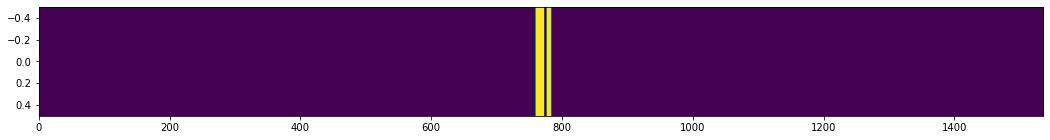

In [15]:
fig, ax = plt.subplots(figsize=(18, 2))
ax.imshow(bin_vector(myc_input['tss_tokens'].values[0].numpy(),1536,128)[tf.newaxis], aspect = "auto", cmap="viridis")
#ax.gca().set_yticks([])
ax.show()

In [18]:
def plot_track_seq(input_arr, start, stop, height=1.5):
    length=stop-start


    # Set y-limit, making neg y-values not show in plot
    #plt.ylim(start, stop)
    x_vals = np.linspace(start,stop,num=length)
    baseline = np.zeros_like(x_vals)
    # Filling between line y3 and line y4
    fig, ax = plt.subplots(figsize=(18, 2))
    ax.fill_between(x_vals, baseline, input_arr[start:stop],alpha=0.9)

    #ax.show()
    

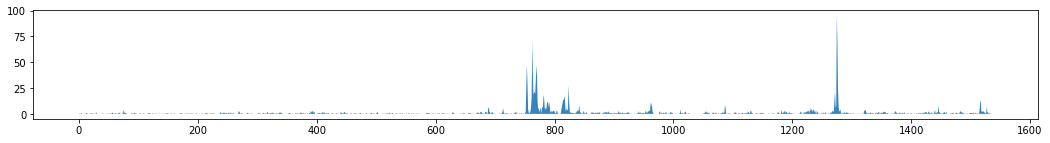

In [20]:
def bin_vector(input_arr, num_bins, output_res):
    return np.sum(np.abs(input_arr).reshape(num_bins, output_res), axis=1)


plot_track_seq(bin_vector(myc_input['atac'].values[0].numpy(),1536,128), 0,1536)

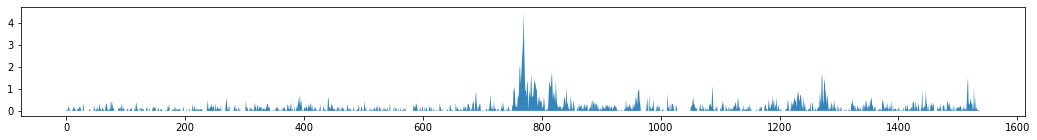

In [21]:
plot_track_seq(bin_vector(myc_scores[2].numpy(),1536,128), 0,1536)

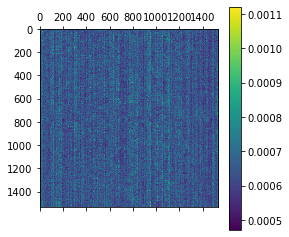

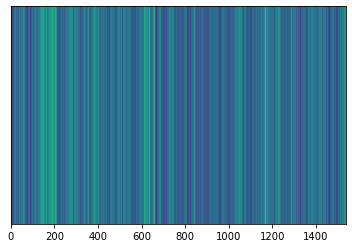

In [22]:
inputs = myc_input['inputs'].values[0],myc_input['atac'].values[0], myc_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_0']

mat = tf.nn.softmax(tf.matmul(q_1[:,0,0,:],tf.transpose(k_1[:,0,0,:])) / tf.math.sqrt(128.0))
for i in range(1,4):
    mat += tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
mat = mat / 4.0


plt.matshow(mat)
plt.colorbar()
plt.show()

promoter_att = tf.reduce_sum(mat[765:772,:],axis=0)

plt.imshow((promoter_att[tf.newaxis]), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

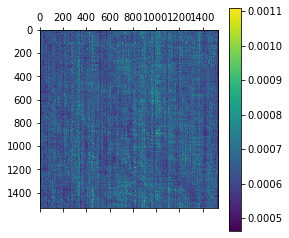

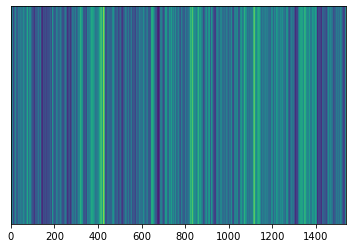

In [19]:
inputs = myc_input['inputs'].values[0],myc_input['atac'].values[0], myc_input['TF_acc'].values[0]
att_matrices = model.predict_on_batch(inputs)[1]
k_1,q_1 = att_matrices['layer_1']
mat = tf.nn.softmax(tf.matmul(q_1[:,0,0,:],tf.transpose(k_1[:,0,0,:])) / tf.math.sqrt(128.0))
for i in range(1,4):
    mat += tf.nn.softmax(tf.matmul(q_1[:,0,i,:],tf.transpose(k_1[:,0,i,:])) / tf.math.sqrt(128.0))
mat = mat / 4.0
plt.matshow(mat)
plt.colorbar()
plt.show()

promoter_att = tf.reduce_sum(mat[765:772,:],axis=0)

plt.imshow((promoter_att[tf.newaxis]), aspect = "auto", cmap="viridis")
plt.gca().set_yticks([])
plt.show()

In [15]:
mat

<tf.Tensor: shape=(1536, 1536), dtype=float32, numpy=
array([[0.00066193, 0.00060628, 0.00053127, ..., 0.00069872, 0.00097005,
        0.00089052],
       [0.00070133, 0.00064897, 0.00053771, ..., 0.00092896, 0.00133372,
        0.00117343],
       [0.0008353 , 0.00068089, 0.00064401, ..., 0.00091589, 0.00084132,
        0.00079346],
       ...,
       [0.00071905, 0.00052927, 0.0005379 , ..., 0.00055318, 0.00065976,
        0.00067259],
       [0.00067786, 0.00050313, 0.00059262, ..., 0.00060043, 0.00070116,
        0.00076149],
       [0.00074746, 0.00056157, 0.00061718, ..., 0.00059508, 0.00064173,
        0.00066891]], dtype=float32)>

In [17]:
for i in range(4):
    print(i)

0
1
2
3


In [8]:
myc_input['exons']

PerReplica:{
  0: <tf.Tensor: shape=(1,), dtype=int32, numpy=array([196608], dtype=int32)>,
  1: <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  2: <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  3: <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  4: <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  5: <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  6: <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>,
  7: <tf.Tensor: shape=(0,), dtype=int32, numpy=array([], dtype=int32)>
}